In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import datetime

In [2]:
# Provided data
data = {
    'Date': ['21/04/2025', '24/04/2025', '29/04/2025'],
    'Weight (kg)': [100.0, 99, 98]
}
df = pd.DataFrame(data)

height = 18 #put the height in cm
age = 30 #put the age in years
sex = 'w' # 'M' for man or 'W' for woman
last_recorded_weight = df['Weight (kg)'].iloc[-1] #get the last recorded weight from the dataframe
provided_tmb = 1300 #took from a bioimpedance 

# Convert 'Date' to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Convert dates to ordinal numbers for regression
df['Date_ordinal'] = df['Date'].apply(lambda date: date.toordinal())

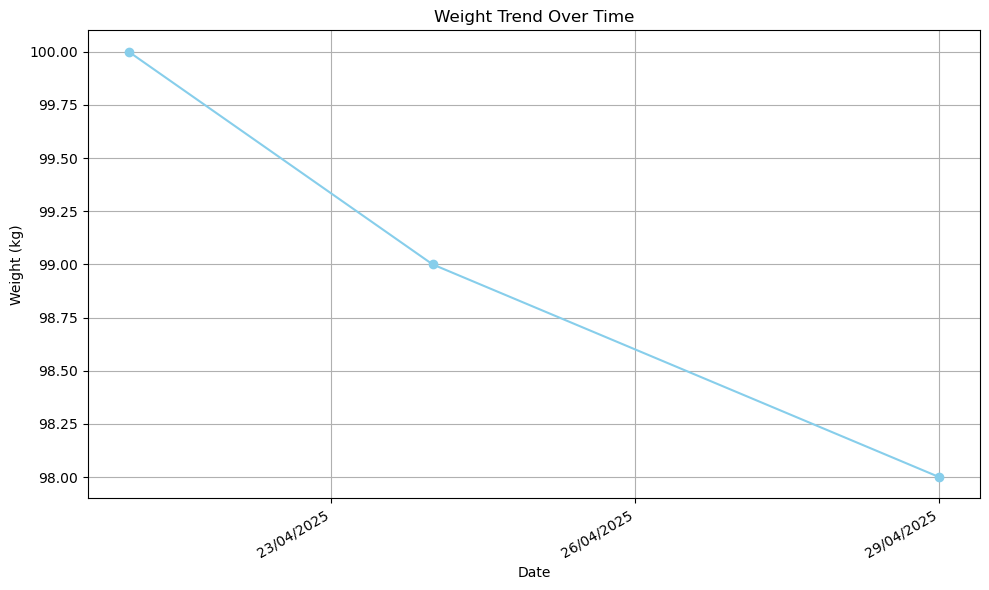

In [3]:
## Fit a linear regression model

# Plotting the data
plt.figure(figsize=(10, 6)) # Set the figure size for better readability
plt.plot(df['Date'], df['Weight (kg)'], marker='o', linestyle='-', color='skyblue')

# Format the x-axis to display dates clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3)) # Show ticks every 3 days
plt.gcf().autofmt_xdate() # Rotate date labels for better visibility

# Add labels and title
plt.title('Weight Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.grid(True) # Add a grid for easier reading of values
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [4]:
# Prepare data for linear regression
X = df['Date_ordinal'].values.reshape(-1, 1)
y = df['Weight (kg)'].values

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [5]:
# Predict weights based on the original dates (for plotting the regression line)
y_pred = model.predict(X)

# Target weights for prediction
target_weights = np.array([90, 80, 70]).reshape(-1, 1) # Target weights to predict dates - substitute with your own values

# Predict dates for target weights
# We need to rearrange the linear equation: y = mx + c  => x = (y - c) / m
# where y is weight, x is date_ordinal, m is coef_, and c is intercept_
predicted_dates_ordinal_float = (target_weights - model.intercept_) / model.coef_

# Convert predicted ordinal dates (which are floats) to integer ordinals, then to datetime objects
predicted_dates = []
for date_ordinal_float in predicted_dates_ordinal_float.flatten():
    # Convert float ordinal to int. Depending on the application,
    # one might round, ceil, or floor. Here, int() truncates.
    # Let's use round() for a potentially more accurate date.
    ordinal_int = int(round(date_ordinal_float))
    try:
        # Ensure the ordinal is within a reasonable range for datetime.fromordinal
        # Python's datetime.fromordinal typically handles ordinals from 1 up to datetime.max.toordinal()
        if 1 <= ordinal_int <= datetime.max.toordinal():
            dt_object = datetime.fromordinal(ordinal_int)
            predicted_dates.append(pd.Timestamp(dt_object)) # Convert to pandas Timestamp for consistency
        else:
            # Handle out-of-bounds ordinal, e.g., by appending None or raising an error
            print(f"Warning: Predicted ordinal {ordinal_int} is out of bounds for date conversion.")
            predicted_dates.append(pd.NaT) # Use NaT for dates that cannot be represented
    except ValueError as e:
        print(f"Warning: Could not convert ordinal {ordinal_int} to date: {e}")
        predicted_dates.append(pd.NaT)


# Filter out NaT values for plotting and printing, if any
valid_predicted_dates = [d for d in predicted_dates if pd.notna(d)]
valid_target_weights = [target_weights.flatten()[i] for i, d in enumerate(predicted_dates) if pd.notna(d)]

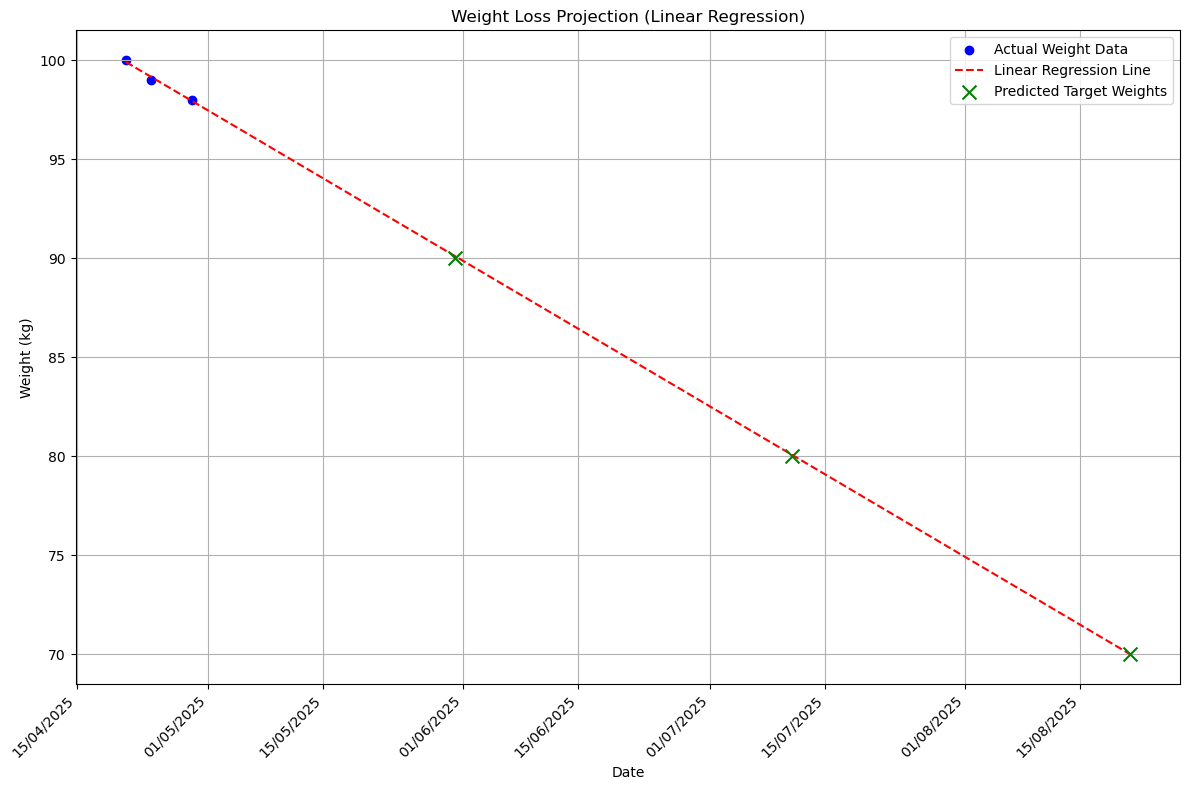

Average Daily Weight Loss Calculation and Projection

Average daily weight loss: 0.245 kg

Predicted dates for target weights:
90 kg: 31/05/2025
80 kg: 11/07/2025
70 kg: 21/08/2025


In [6]:
# Create the plot
plt.figure(figsize=(12, 8)) # Increased height a bit for better layout

# Scatter plot of the original data
plt.scatter(df['Date'], y, color='blue', label='Actual Weight Data')

# Plot the linear regression line
# Extend the regression line to cover the range of predictions
all_dates_ordinal = np.concatenate((X.flatten(), [pd.Timestamp(d).toordinal() for d in valid_predicted_dates if pd.notna(d)]))
all_dates_ordinal_sorted = np.sort(np.unique(all_dates_ordinal))
extended_X_ordinal = all_dates_ordinal_sorted.reshape(-1,1)
extended_y_pred = model.predict(extended_X_ordinal)
extended_dates = [datetime.fromordinal(int(o)) for o in extended_X_ordinal.flatten()]

plt.plot(extended_dates, extended_y_pred, color='red', linestyle='--', label='Linear Regression Line')


# Scatter plot of the predicted dates for target weights
if valid_predicted_dates:
    plt.scatter(valid_predicted_dates, valid_target_weights, color='green', marker='x', s=100, label='Predicted Target Weights', zorder=5)

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Weight Loss Projection (Linear Regression)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=12))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Calculate the average daily loss of weight
# The coefficient of the model represents the average change in weight per day
average_daily_loss = model.coef_[0]  # This is a scalar value representing the slope of the regression line

print("==========================================================")
print("Average Daily Weight Loss Calculation and Projection")

print(f"\nAverage daily weight loss: {abs(average_daily_loss):.3f} kg")

# Print the predicted dates
print("\nPredicted dates for target weights:")
for weight, date in zip(target_weights.flatten(), predicted_dates): # Use original predicted_dates to show NaT if any
    if pd.notna(date):
        print(f"{weight} kg: {date.strftime('%d/%m/%Y')}")
    else:
        print(f"{weight} kg: Date prediction out of bounds or invalid.")

print("==========================================================")

In [7]:
## Predicting Weight Loss - Average needed to reach a target weight by a specific date

# --- The Prediction and Plotting Function ---

def plot_required_projection(historical_df, model, target_weight, target_date):
    """
    A helper function to generate a plot showing historical data,
    the original trend, and the required path to a new target.
    """
    plt.figure(figsize=(12, 8))

    # 1. Plot historical data points
    plt.scatter(historical_df['Date'], historical_df['Weight (kg)'], color='blue', label='Historical Weight Data', zorder=5)

    # 2. Plot the original linear regression trend line for context
    # We extend the line 30 days past the last entry to show the trend
    extended_dates_ord = np.array([
        historical_df['Date_ordinal'].min(),
        historical_df['Date_ordinal'].max() + 30
    ]).reshape(-1, 1)
    extended_dates = [datetime.fromordinal(int(o)) for o in extended_dates_ord.flatten()]
    trend_line = model.predict(extended_dates_ord)
    plt.plot(extended_dates, trend_line, color='red', linestyle='--', label='Original Trend (Regression)')

    # 3. Plot the required projection line from the last known point to the target
    last_historical_date = historical_df['Date'].iloc[-1]
    last_historical_weight = historical_df['Weight (kg)'].iloc[-1]
    
    projection_dates = [last_historical_date, target_date]
    projection_weights = [last_historical_weight, target_weight]
    
    plt.plot(projection_dates, projection_weights, color='green', linestyle='-', marker='o', label=f'Required Path to {target_weight}kg')
    
    # Highlight the final target point with a star
    plt.scatter([target_date], [target_weight], color='purple', marker='*', s=200, label='Final Target', zorder=10)

    # --- Formatting the plot ---
    plt.title('Weight Projection: Historical Trend vs. Required Path')
    plt.xlabel('Date')
    plt.ylabel('Weight (kg)')
    plt.legend()
    plt.grid(True)
    
    # Format the date axis for clarity
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))
    plt.xticks(rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

def predict_and_plot_weight_loss(current_weight, target_weight, target_date_str, historical_df, model):
    """
    Calculates the daily weight loss needed to reach a target weight by a specific date,
    and plots the projection if the target is 90 kg or more.

    Args:
        current_weight (float): The starting weight in kg.
        target_weight (float): The desired target weight in kg.
        target_date_str (str): The target date in 'dd/mm/YYYY' format.
        historical_df (pd.DataFrame): DataFrame with historical 'Weight (kg)' and 'Date'.
        model (LinearRegression): The pre-trained linear regression model.
    """
    # --- Calculation Part ---
    try:
        target_date = datetime.strptime(target_date_str, '%d/%m/%Y')
    except ValueError:
        print("Error: Invalid date format. Please use 'dd/mm/YYYY'.")
        return

    # Using datetime.now() without time for a clean daily comparison
    today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

    if target_date <= today:
        print("Error: Target date must be in the future.")
        return

    if target_weight >= current_weight:
        print("Error: Target weight must be less than current weight to calculate weight loss.")
        return

    days_to_target = (target_date - today).days
    total_weight_to_lose = current_weight - target_weight
    
    # Calculate daily loss in kg and grams for better readability
    daily_loss_kg = total_weight_to_lose / days_to_target
    daily_loss_grams = daily_loss_kg * 1000

    print("=" * 80)
    print("Average Daily Weight Loss Needed to Reach Target Weight by Specific Date")
    print("=" * 80)
    print(f"\n--- Weight Loss Calculation ---")
    print(f"Current Weight: {current_weight} kg")
    print(f"Target Weight: {target_weight} kg")
    print(f"Target Date: {target_date_str}")
    print(f"Days to Target: {days_to_target}")
    print(f"Total Weight to Lose: {total_weight_to_lose:.2f} kg")
    print("-" * 30)
    print(f"Required Daily Loss: {daily_loss_kg:.3f} kg (or {daily_loss_grams:.1f} grams) per day.")
    print("-" * 30)
    print("=" * 80)

    # --- Conditional Plotting Part ---
    if target_weight < last_recorded_weight:
        print("\nNOTE: The final target has been surpassed. No plot will be generated.")
    else:
        print("\nGenerating weight loss projection plot...")
        plot_required_projection(historical_df, model, target_weight, target_date)

In [8]:
# Predicted average daily weight loss to reach the target weight

# Get the last recorded weight from the dataframe to use as the 'current_weight'
last_recorded_weight = df['Weight (kg)'].iloc[-1]

# ----> Using the function to predict and plot weight loss
predict_and_plot_weight_loss(
    current_weight=last_recorded_weight, 
    target_weight=70, #set the target weight
    target_date_str="31/12/2025", ##settle this to a future date
    historical_df=df,
    model=model
)

Average Daily Weight Loss Needed to Reach Target Weight by Specific Date

--- Weight Loss Calculation ---
Current Weight: 98.0 kg
Target Weight: 70 kg
Target Date: 31/12/2025
Days to Target: 202
Total Weight to Lose: 28.00 kg
------------------------------
Required Daily Loss: 0.139 kg (or 138.6 grams) per day.
------------------------------

NOTE: The final target has been surpassed. No plot will be generated.


In [9]:
#Basal Metabolic Rate (TMB) Calculation

# --- TMB Calculation Function (Harris-Benedict Equation) ---
# STEP 1: Define the function (the "recipe"). 
def calculate_tmb(weight, height, age, sex):
    """Calculates Basal Metabolic Rate (TMB) using the Harris-Benedict equation."""
    # The '.upper()' makes the check case-insensitive (accepts 'm' or 'M')
    if sex.upper() == 'M':
        # Formula for men
        return 66 + (13.8 * weight) + (5 * height) - (6.8 * age)
    # 'else' handles any other case, which we assume is 'W'
    else:
        # Formula for women
        return 655 + (9.6 * weight) + (1.8 * height) - (4.7 * age)


# --- Calculation ---
# STEP 2: Call the function with the inputs and store the result in the variable.
calculated_tmb = calculate_tmb(last_recorded_weight, height, age, sex)

# --- Output and Comparison ---
# Now the rest of your code will work correctly.
print("="*60)
print(f"Calculated TMB: {calculated_tmb:.2f} calories/day")
print(f"Provided TMB:   {provided_tmb:.2f} calories/day")
print("="*60)

if provided_tmb > calculated_tmb:
    print("Result: The provided TMB is larger than the calculated TMB.")
elif provided_tmb < calculated_tmb:
    print("Result: The provided TMB is lesser than the calculated TMB.")
else:
    print("Result: The provided TMB is equal to the calculated TMB.")

print("="*60)

Calculated TMB: 1487.20 calories/day
Provided TMB:   1300.00 calories/day
Result: The provided TMB is lesser than the calculated TMB.
